In [10]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from _plotly_future_ import v4_subplots
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [73]:
n_samples = 500

# generate random sample, two components
np.random.seed(0)

# # generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# # generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# # concatenate the two datasets into the final training set
# X_train = np.vstack([shifted_gaussian, stretched_gaussian])

X_train = stretched_gaussian

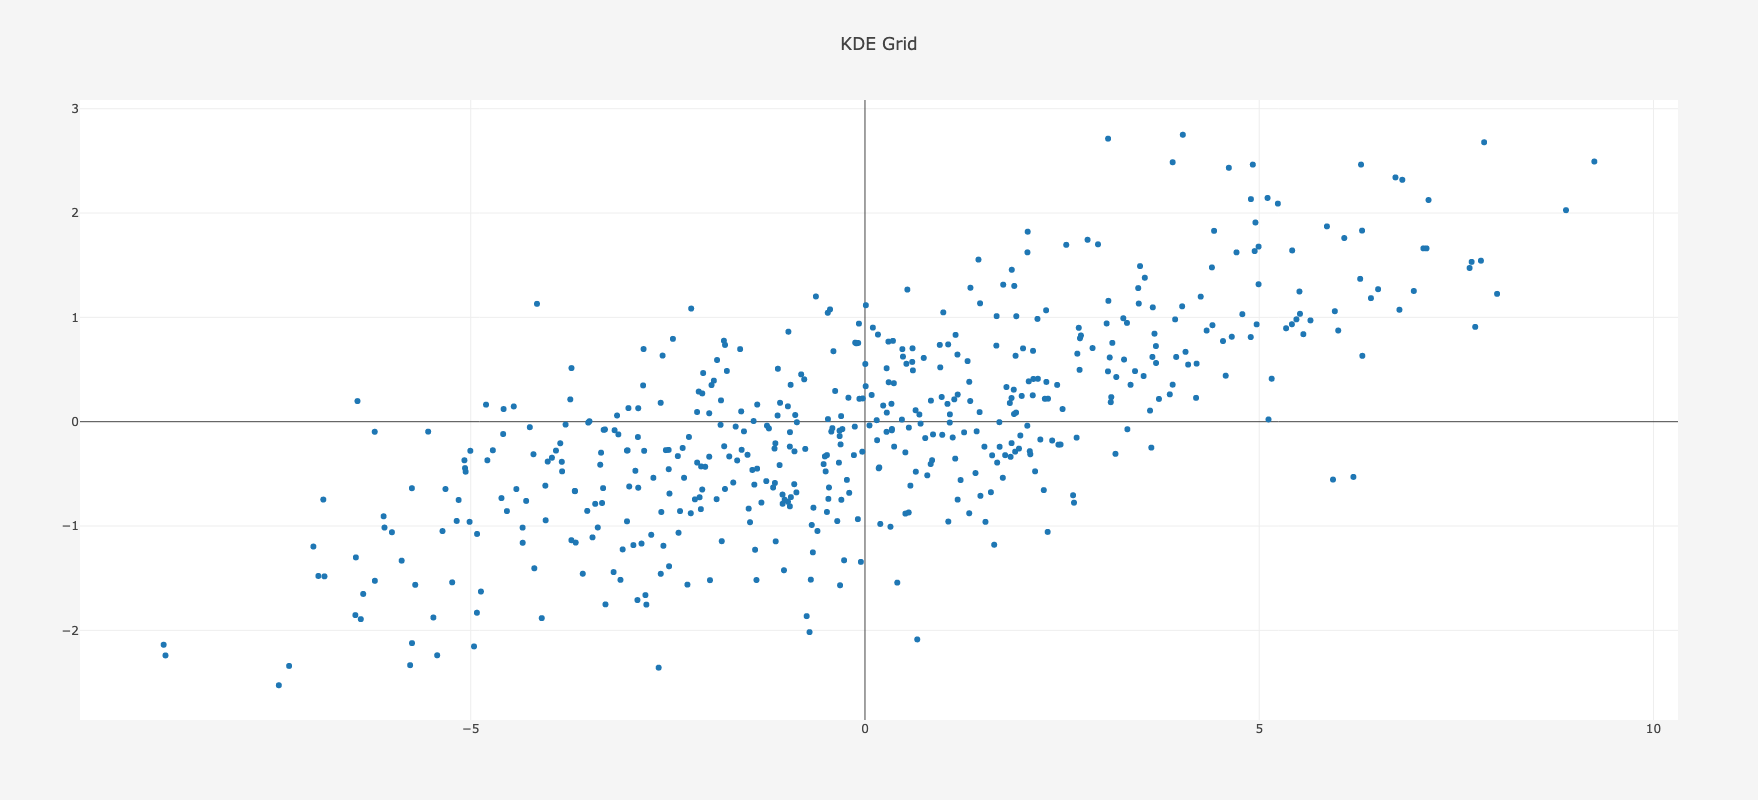

In [75]:
pts = go.Scatter(
    x=X_train[:,0],
    y=X_train[:,1],
    mode="markers"
)

layout = go.Layout(
    title="KDE Grid",
    autosize=False,
    width=1200,
    height=800,
    paper_bgcolor='#F5F5F5'
)

iplot(
    go.Figure(
        [pts],layout
    )
)

In [88]:
nbins  = 50
xedges = np.linspace(-8,8,nbins+1)
yedges = np.linspace(-3,3,nbins+1)

xx, yy = np.meshgrid(xedges,yedges)
grid = np.array([x for x in zip(xx.ravel(), yy.ravel())])

In [89]:
# %%timeit
# grid = [x for xy in zip(xx,yy) for x in zip(*xy) ]
# grid[:10]

In [90]:
# %%timeit
# grid = np.array([x for x in zip(xx.ravel(), yy.ravel())])
# grid[:5]

In [91]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X_train)

log_dens_kde=kde.score_samples(grid)
(np.exp(log_dens_kde))[:5]

array([8.80104005e-06, 2.31054870e-04, 4.82908663e-04, 8.40337463e-05,
       1.32585652e-06])

In [92]:
kde_hmap = np.exp(log_dens_kde.reshape(nbins+1,nbins+1))

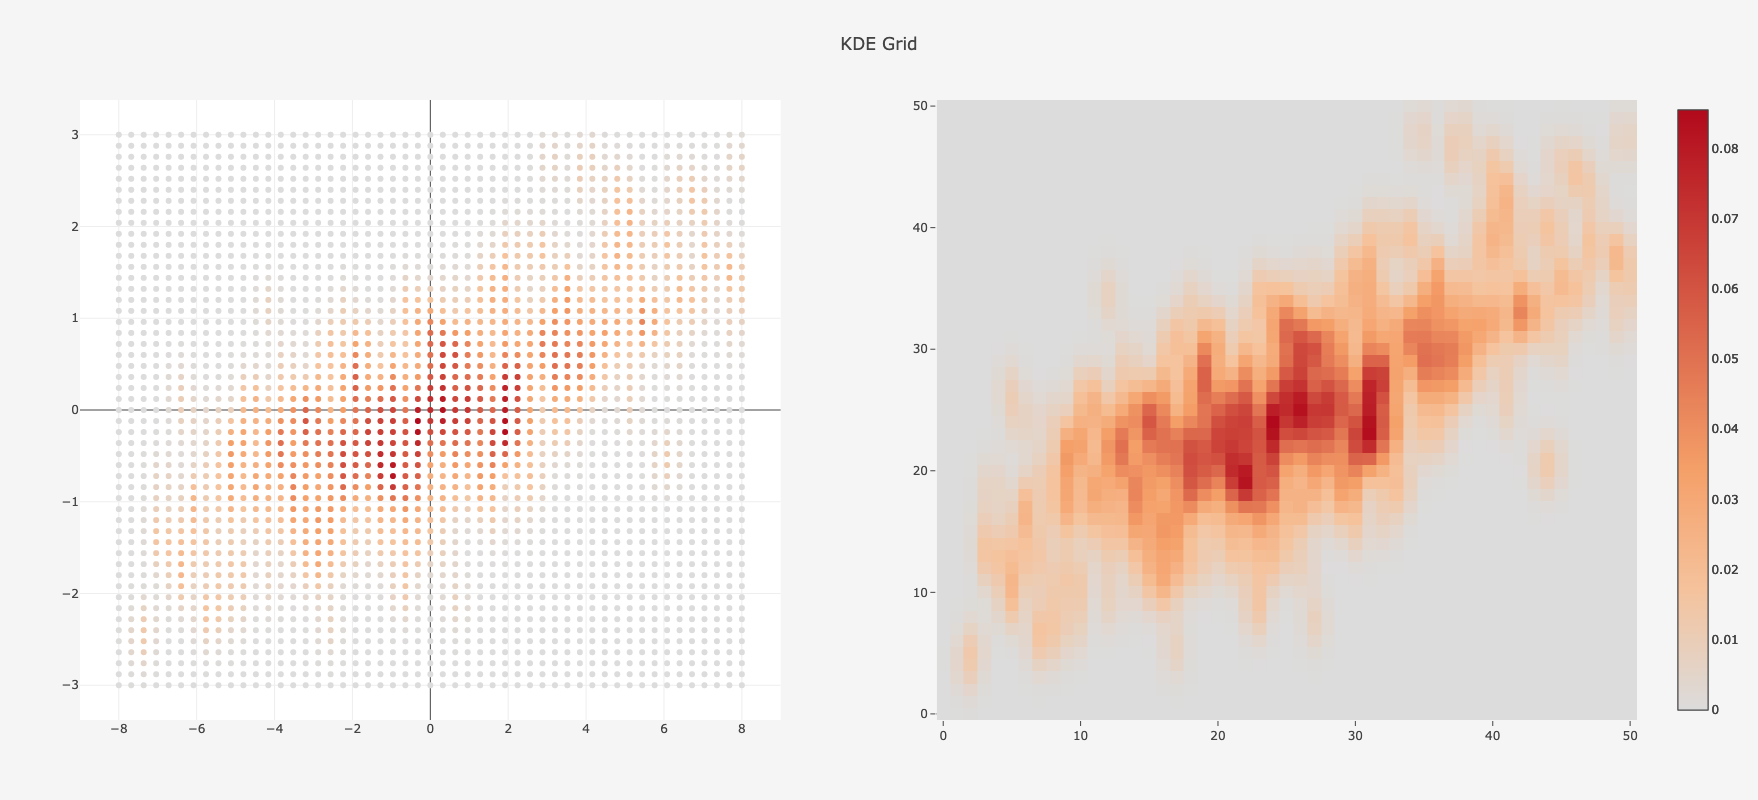

In [93]:
grid_pts = go.Scatter(
                x=grid[:,0],
                y=grid[:,1],
                mode="markers",
                marker=dict(
                    color=np.exp(log_dens_kde),
                    showscale=True
                ),
                text=np.exp(log_dens_kde)
            )

grid_hm = go.Heatmap(
    z=kde_hmap,
    colorscale = 'Reds'
)

layout = go.Layout(
    title="KDE Grid",
    autosize=False,
    width=1600,
    height=800,
    paper_bgcolor='#F5F5F5'
)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(grid_pts, row=1,col=1)
fig.add_trace(grid_hm, row=1,col=2)
fig.layout.update(layout)

# go.Figure(data=[grid_hm], layout=layout)
iplot(fig)

In [94]:
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=0.2, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

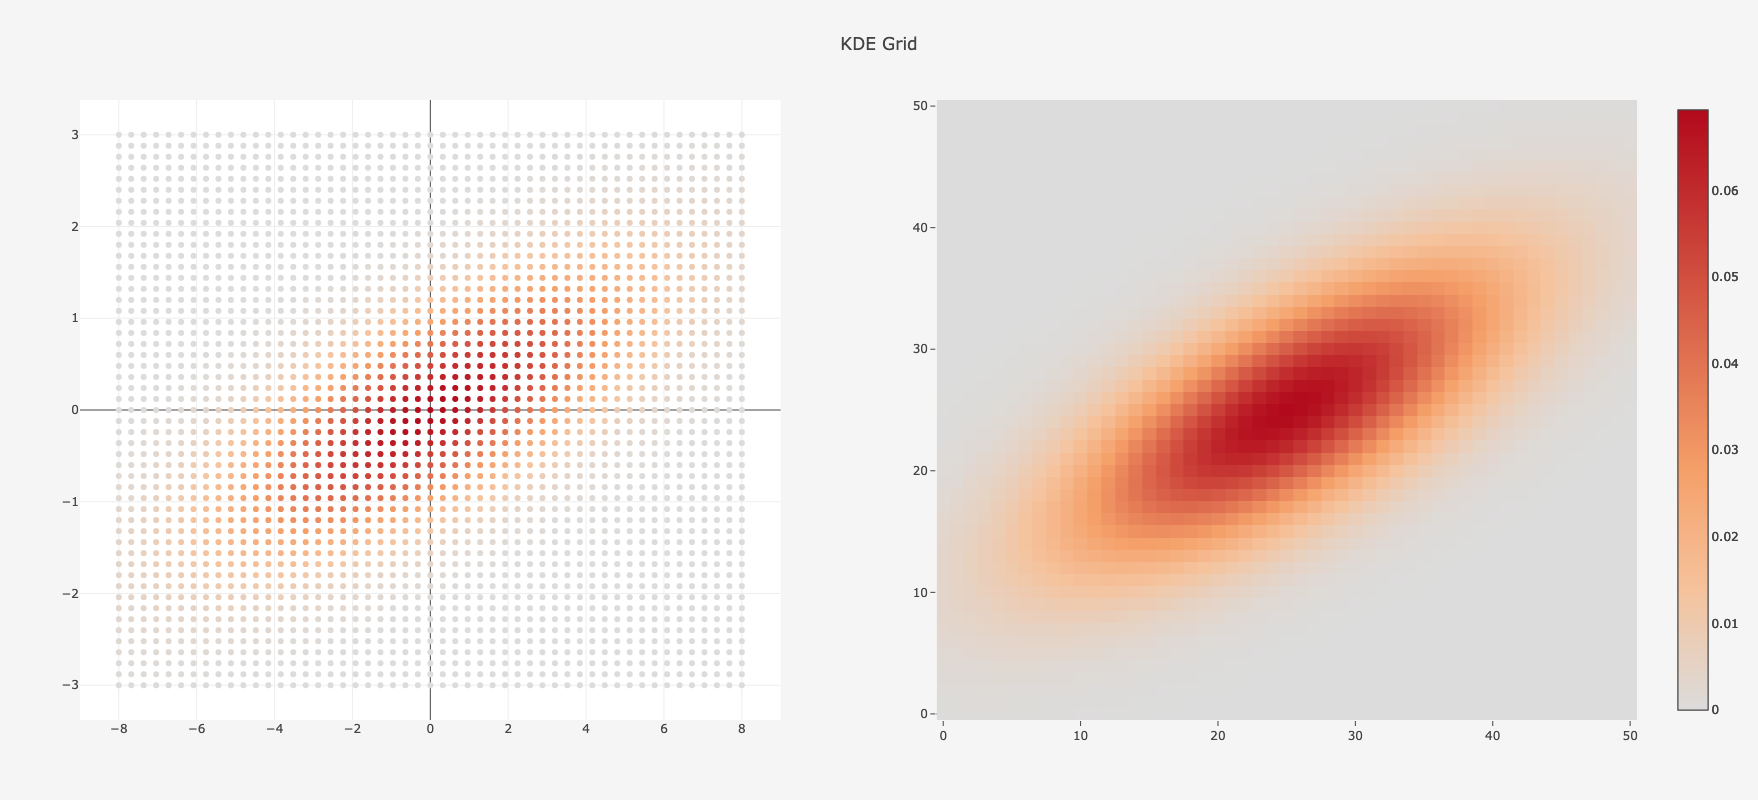

3700.0127949977045

In [97]:
gmm = GaussianMixture(n_components=1).fit(X_train)

log_dens_gmm=gmm.score_samples(grid)
grid_pts["marker"]["color"] = np.exp(log_dens_gmm)
grid_hm["z"] = np.exp(log_dens_gmm).reshape(nbins+1,nbins+1)


fig = make_subplots(rows=1, cols=2)

fig.add_trace(grid_pts, row=1,col=1)
fig.add_trace(grid_hm, row=1,col=2)

fig.layout.update(layout)

iplot(fig)
gmm.bic(X_train)

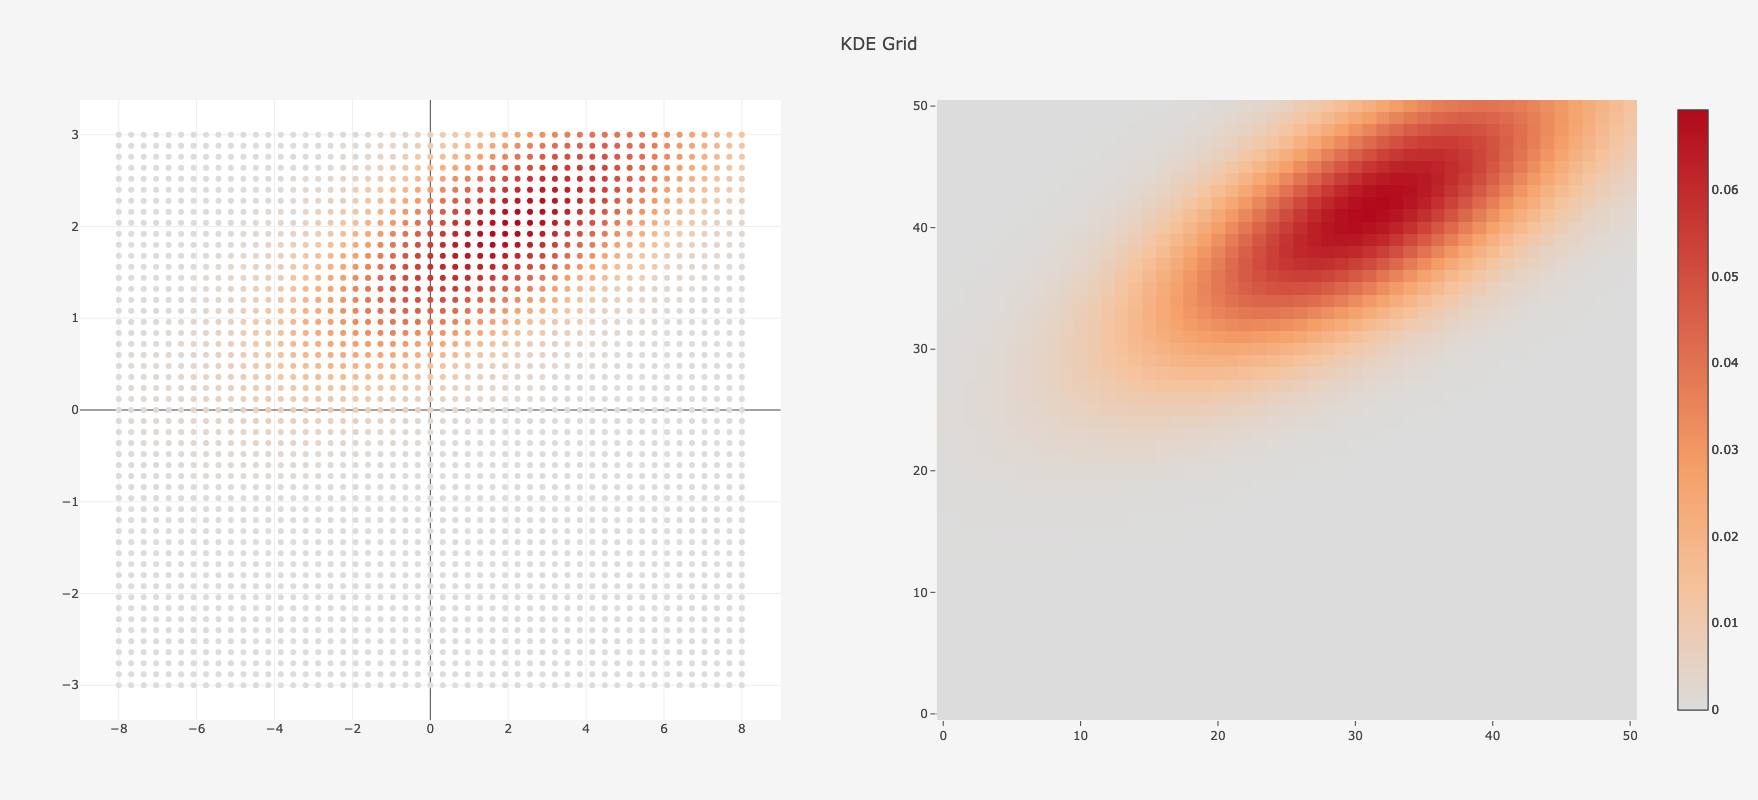

In [98]:
gmm = GaussianMixture(n_components=1).fit(X_train+2)

log_dens_gmm=gmm.score_samples(grid)
grid_pts["marker"]["color"] = np.exp(log_dens_gmm)
grid_hm["z"] = np.exp(log_dens_gmm).reshape(nbins+1,nbins+1)


fig = make_subplots(rows=1, cols=2)

fig.add_trace(grid_pts, row=1,col=1)
fig.add_trace(grid_hm, row=1,col=2)
fig.layout.update(layout)

iplot(fig)


In [51]:
gmm.bic(X_train+2)

1668.7851376401243

In [99]:
%%time

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(X_train)
        bic.append(gmm.bic(X_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
best_gmm

CPU times: user 151 ms, sys: 2.62 ms, total: 153 ms
Wall time: 152 ms


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

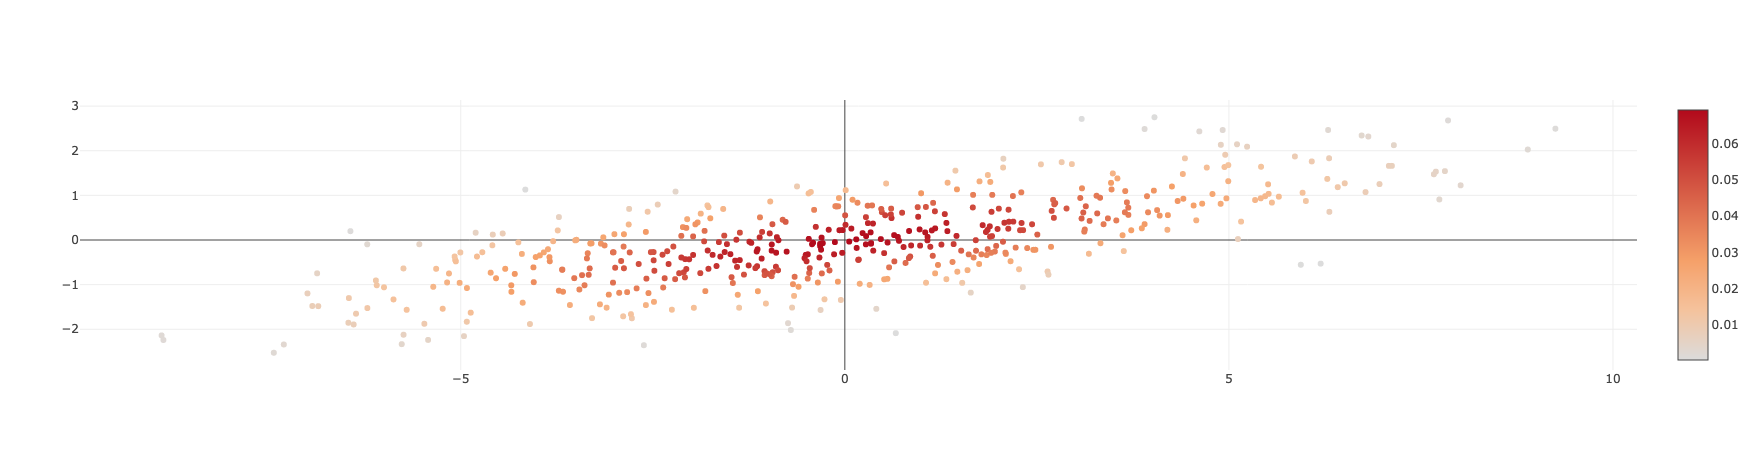

3700.0127949977045

In [100]:
log_dens_gmm=best_gmm.score_samples(X_train)

pts["marker"]["color"] = np.exp(log_dens_gmm)
pts["marker"]["showscale"]=True
iplot([pts])
best_gmm.bic(X_train)

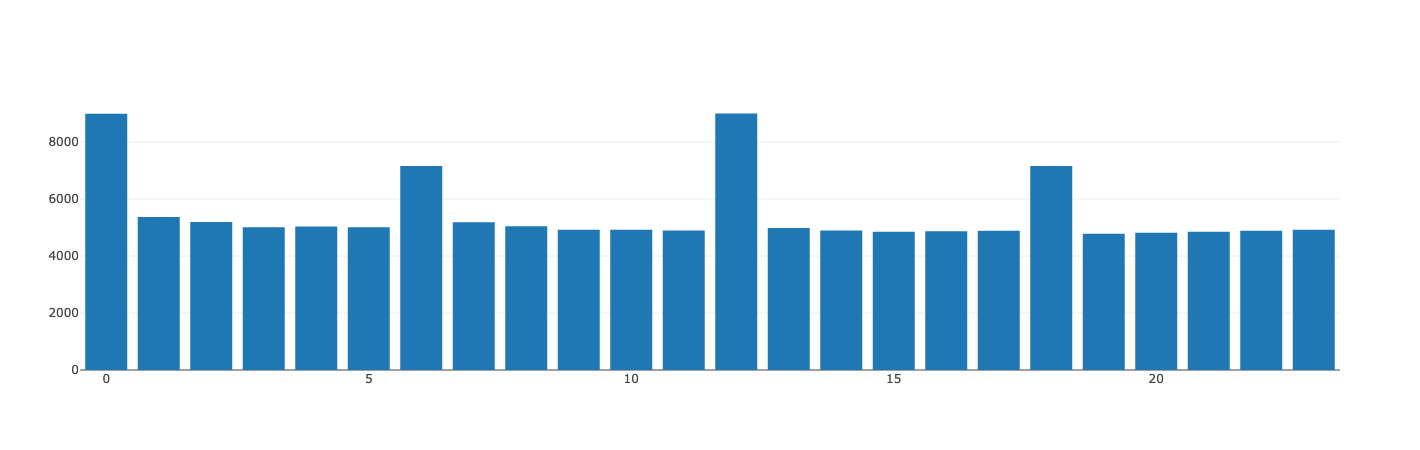

In [44]:
# bic_bar = go.Bar(
#     x=[x for x in range(0,len(bic))],
#     y=bic
# )
# iplot([bic_bar])

## Histogramming Data as Density Estimate

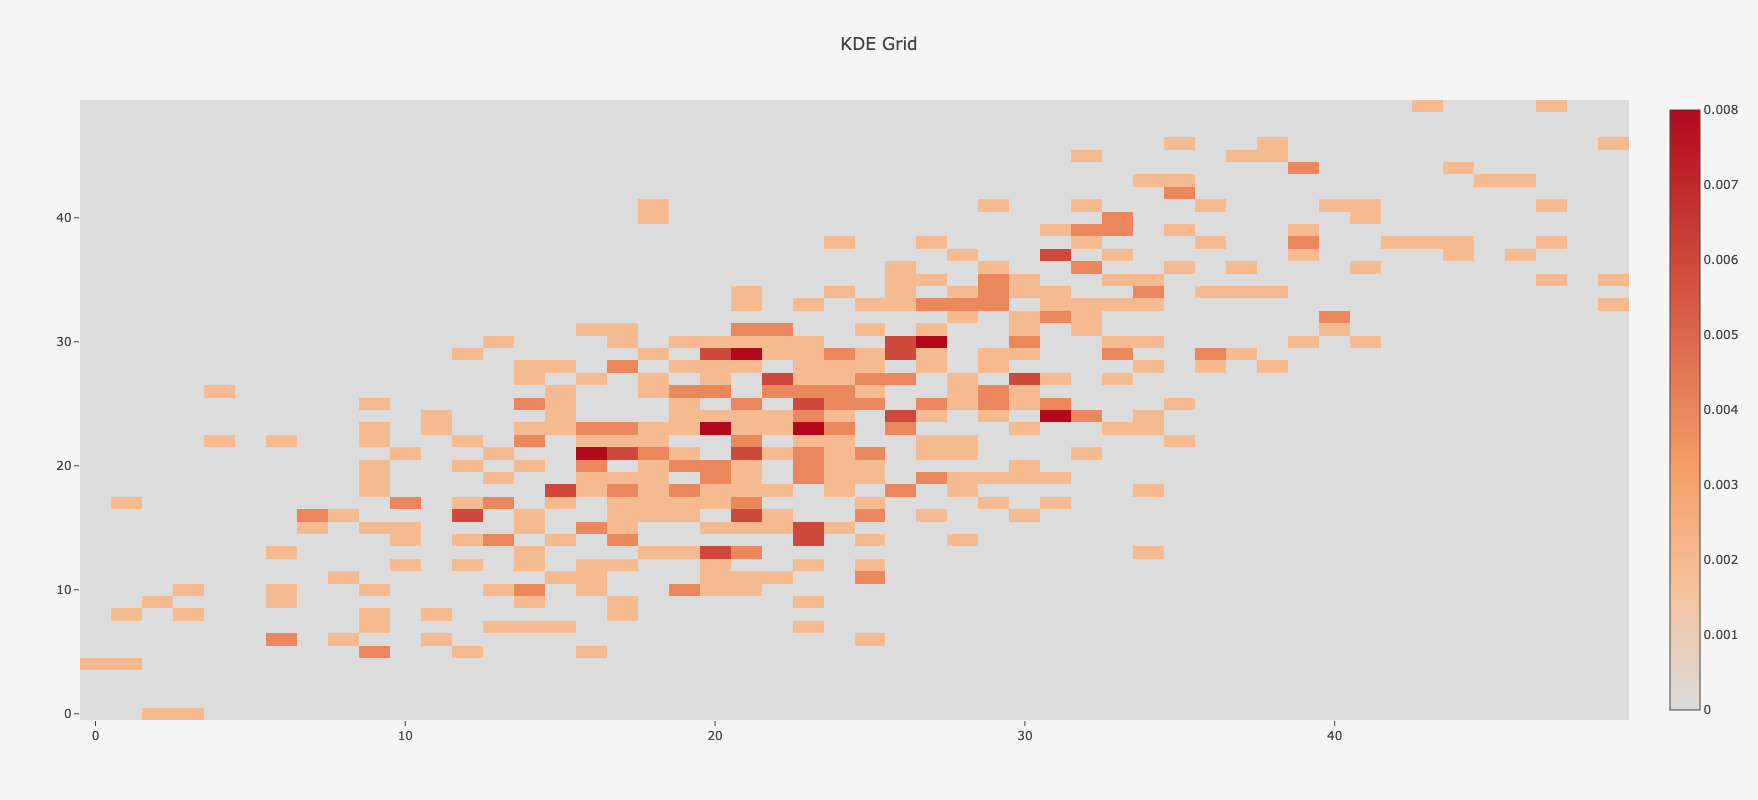

In [102]:
nbins=50
hist, edges = np.histogramdd(X_train, bins=nbins)
hist_densities = (hist/n_samples)

hist_hm = go.Heatmap(
    z=hist_densities,
    colorscale = 'Reds'
)

layout = go.Layout(
    title="KDE Grid",
    autosize=False,
    width=800,
    height=800,
    paper_bgcolor='#F5F5F5'
)

fig = go.Figure(data=[hist_hm], layout=layout)

iplot(fig)